Chi = 656.5480877188933
L = 8.94387755797477e+31


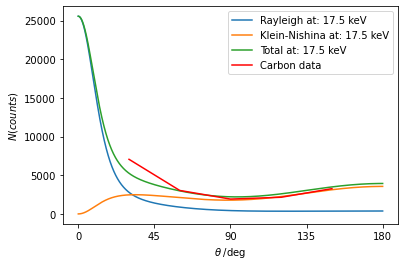

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
import scipy.optimize as opt
from scipy.optimize import minimize, least_squares
from scipy.constants import e, h, hbar, alpha, c, m_e
# A bunch of constants factored into a single variable. This is half the classical electron radius
f = (hbar * alpha / m_e / c)**2 / 2

# A grid of scattering angles in rad.
theta = np.arange(0, 180, 0.01)
n = len(theta)

# factor to take degrees to radians because its stupid
d = np.pi/180
E = 0.0175 #in MeV
ad = pd.read_excel('AtomicFormParams.xlsx')
ad.index=[1,6,8,27,62]
#print(aD)


# plot experimental data
x = [] # thetas
y = [] # counts
z = [] # errors

with open('Carbon.csv') as File:  
    Line_reader = csv.reader(File, delimiter=',')
    for row in Line_reader:
        x.append(float(row[0]))
        y.append(float(row[3]))
        z.append(float(row[4]))



# functions for the (uncorrected) KN and Thompson cross sections as a function of energy and scattering angle(in degrees)
def KleinNishina(E,phi):
    nu = E * 1.e6 * e / h
    lam = c / nu
    lamp = lam + h / m_e / c * (1 - np.cos(phi*d))
    P = lam / lamp
    dsigma_dOmegaKN = f * P**2 * (P + 1/P - np.sin(phi*d)**2) 
    return dsigma_dOmegaKN

def Thompson(phi):
    dsigma_dOmegaR = f * (1 + np.cos(phi*d)**2) 
    return dsigma_dOmegaR

# functions to compute the Atomic form factor F

def F(theta, Z):
    # some variable definitions
    x = 41.2148 * (E/(0.511)) * np.sin(d*0.5*theta)
    q = 2*E/c * np.sin(d*theta/2)
    a = (Z - (5/16))*alpha
    gamma = (1-a**2)**0.5
    Q = q / (2*m_e*c*a)
    f = Z*(1 + ad.at[Z,'a1']*x**2 + ad.at[Z,'a2']*x**3 + ad.at[Z,'a3']*x**4)/(1 + ad.at[Z,'a4']*x**2 + ad.at[Z,'a5']*x**4)**2
    if Z>10 and f < 2:
        F_k = (np.sin(2*gamma*np.arctan(Q)))/(gamma*Q*(1+Q**2)**gamma)
        return max(f,F_k)
    else:
        return f
    
# atomic form factor but in F(x,Z)
def Fx(x, Z):
    f = Z*(1 + ad.at[Z,'a1']*x**2 + ad.at[Z,'a2']*x**3 + ad.at[Z,'a3']*x**4)/(1 + ad.at[Z,'a4']*x**2 + ad.at[Z,'a5']*x**4)**2
    return f


# function to compute the incoherent scattering factor S

def S(theta, Z):
    x = 41.2148 * (E/(0.511)) * np.sin(d/2*theta)
    s = Z*(1 -(1 + ad.at[Z,'b1']*x**2 + ad.at[Z,'b2']*x**3 + ad.at[Z,'b3']*x**4)/(1 + ad.at[Z,'b4']*x**2 + ad.at[Z,'b5']*x**4)**2)
    return s

def plot_diff_xsec(Z,E):
    """Plot the differential cross section for incoming photon energy, E."""
    Ek = E*10**3
    # Plot Rayleigh.
    ax2.plot(theta, result.x *Thompson(theta)*(F(theta,Z)**2),
             label= 'Rayleigh at: ' + str(Ek) + r' keV')
    # Plot Klein-Nishina
    ax2.plot(theta, result.x * KleinNishina(E,theta)*S(theta,Z),
             label='Klein-Nishina at: ' + str(Ek) + r' keV')
    # Plot the total csection
    ax2.plot(theta, result.x *(Thompson(theta)*F(theta,Z)**2 + KleinNishina(E,theta)*S(theta,Z)), 
             label='Total at: ' + str(Ek) + r' keV')

    
fig, ax2 = plt.subplots()

Z = 6

#write function to compute chi-squared as a function of a scaling factor l
def chi(l):
    chiSquare = 0
    for i,b in enumerate(x):
        chiSquare = chiSquare + (l * (KleinNishina(E,b)*S(b,Z) + Thompson(b)*(F(b,Z)**2)) - y[i])**2 / z[i]**2
    #print(chiSquare)
    return chiSquare
result = opt.minimize_scalar(chi, bounds=(3e30,4e34),method='bounded')
print("Chi = " + str(result.fun))
print("L = " + str(result.x))
plot_diff_xsec(Z,E)
plt.plot(x,y,color='r',label="Carbon data")


ax2.set_xlabel(r'$\theta\;/\mathrm{deg}$')
ax2.set_ylabel(r'$N (counts)$')
# Set the Cartesian x-axis ticks to sensible values (in degrees).
ax2.set_xticks([0, 45, 90, 135, 180])
plt.legend()
plt.show()


